In [1]:
import urllib.request
import os.path
import numpy as np
import sys
sys.path.insert(0, './')
from utils import plot_mats

file_name = 'mnist_test_seq.npy'
url = 'http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy'

if not os.path.isfile(file_name):
    print("could not find dataset: download it..")
    urllib.request.urlretrieve(url, file_name)
    print("download complete")

# Moving Mnist: 10.000 sequences of length 20 showing 2 digits moving in 64x64
moving_mnist = np.load(file_name) # shape: 20,10000,64,64
moving_mnist = np.rollaxis(moving_mnist, 1) # --> 10000,20,64,64

In [2]:
class ImageSplitter:
    """ splits the video set into shorts of n frames
    """
    def __init__(self, 
                 dataset,
                 n=3, 
                 ntest=256,
                 batchsize=64):
        """ ctor
            dataset: list of videos that have to be cut into n-grams
            n: integer, length of subsequence
            ntest: integer, number of items that belong to the test set
            batchsize: ~
            
        The data has to be arranged in following order:
            NUMBER_OF_VIDEOS, LENGTH_OF_VIDEO, HEIGHT, WIDTH
            
        """
        
        self.batchsize = batchsize
        self.batch_loop = 0
        self.n = n
        

        np.random.shuffle(dataset)
        
        self.test_set = dataset[0:ntest]
        self.train_set = dataset[ntest:]
        
        F, N, H, W = dataset.shape # Frames, Numbers, Height, Width
        
        
        self.vector_dimension = H * W
        self.same_batch_run = True
        
    def get_dimension(self):
        """ gets the data dimension
        """
        return self.vector_dimension

    def transform_to_n_gram(self, batch, ngram=None):
        """ transforms the batch into an n-gram (parameter n)
        batch: np.array((batchsize, 20, 64, 64))
        """
        if ngram is None:
            n = self.n
        else:
            n = ngram
        N, M, H, W = batch.shape
        seqs = M-n+1 # sequences per video
        
        Result = np.zeros((seqs * N, n, H, W))
        
        pos = 0
        for j in range(N):
            for i in range(seqs):
                Result[pos] = batch[j, i:i+n]
                pos += 1
        
        N, M, H, W = Result.shape
        return Result.reshape((N, M, H * W))
    
    def is_same_batch_run(self):
        if self.same_batch_run:
            return True
        else:
            self.same_batch_run = True
            return False
        
    
    def next_batch(self, ngram=None):
        """ returns the next batch
        """
        start = self.batch_loop
        end = self.batch_loop + self.batchsize
        N = self.train_set.shape[0]
        if N > end:
            self.same_batch_run = True
            self.batch_loop = end
            return self.transform_to_n_gram(
                self.train_set[start:end], ngram=ngram)
        else:
            self.same_batch_run = False
            diff = (N - start)
            end = self.batchsize - diff
            
            set1 = self.train_set[start:N]
            set2 = self.train_set[0:end]
            
            self.batch_loop = end
            return self.transform_to_n_gram(
                np.concatenate((set1, set2)), ngram=ngram)
    
    def get_test(self, ngram=None):
        """ returns the test data as ngram
        """
        return self.transform_to_n_gram(self.test_set, ngram=ngram)

# splitter = ImageSplitter(moving_mnist, n=3)
# batch = splitter.next_batch(ngram=2)
# print(batch[:,0,:].shape)

# test = splitter.get_test(ngram=2)
# print(test.shape)

# print(np.max(test), np.min(test))

In [3]:
import tensorflow as tf

# this function is 'borrowed' from keras
def random_binomial(shape, p=0.0, dtype=None, seed=None):
    """Returns a tensor with random binomial distribution of values.
    # Arguments
        shape: A tuple of integers, the shape of tensor to create.
        p: A float, `0. <= p <= 1`, probability of binomial distribution.
        dtype: String, dtype of returned tensor.
        seed: Integer, random seed.
    # Returns
        A tensor.
    """
    if dtype is None:
        dtype = 'float32'
    if seed is None:
        seed = np.random.randint(10e6)
    return tf.where(tf.random_uniform(shape, dtype=dtype, seed=seed) <= p,
                    tf.ones(shape, dtype=dtype),
                    tf.zeros(shape, dtype=dtype))


class PredictiveGatingPyramid:
    """ implementation of the pgp
    """
    
    def __init__(self, 
                 depth=2, 
                 numfilters=512, 
                 numHidden=256,
                 modelname=None,
                 learning_rate=0.01,
                 normalize_data=True):
        assert depth > 0
        assert depth == 2, "Other depth than 2 not supported"
        self.depth = depth
        self.F = numfilters
        self.H = numHidden
        self.learningRate = learning_rate
        self.is_trained = False
        self.normalize_data = normalize_data
        self.modelname = modelname
        self.is_first_layer_trained = False
        
        
    def save_first_stage(self):
        """ saves the model onto disk
        """
        modelname = self.modelname
        assert(self.is_trained)
        assert modelname is not None
        np.save(modelname + "U1", self.U1_np)
        np.save(modelname + "V1", self.V1_np)
        np.save(modelname + "W1", self.W1_np)
        np.save(modelname + "b_U1", self.b_U1_np)
        np.save(modelname + "b_V1", self.b_V1_np)
        np.save(modelname + "b_W1", self.b_W1_np)
        np.save(modelname + "b_U1_out", self.b_U1_out_np)
        np.save(modelname + "b_V1_out", self.b_V1_out_np)
        np.save(modelname + "b_W1_out", self.b_W1_out_np)
    
    def load_first_stage(self, modelname=None):
        """ loads the first layer of the network
        """
        if modelname is None:
            modelname = self.modelname
        self.U1_np = np.load(modelname + "U1.npy")
        self.V1_np = np.load(modelname + "V1.npy")
        self.W1_np = np.load(modelname + "W1.npy")
        self.b_U1_np = np.load(modelname + "b_U1.npy")
        self.b_V1_np = np.load(modelname + "b_V1.npy")
        self.b_W1_np = np.load(modelname + "b_W1.npy")
        self.b_U1_out_np = np.load(modelname + "b_U1_out.npy")
        self.b_V1_out_np = np.load(modelname + "b_V1_out.npy")
        self.b_W1_out_np = np.load(modelname + "b_W1_out.npy")
        self.is_first_layer_trained = True
    
    
    def train(self, X, epochs=100, pre_epochs=100, print_debug=True,
             load_first_stage=False):
        """ trains the model
        
            X: training data: must be organized as follows:
                Number_of_videos, video_length, H, W
            epochs: number of epochs to run for final training
            pre_epochs: number of epochs for training initial layer
            load_first_stage: if True, then the first stage will not
                be trained separatly but will be loaded from file
                instead
        """
        self.is_trained = True
        
        X = X.astype('float32')  # hopefully we don't run OOMem here..
        
        if self.normalize_data:
            X -= X.mean(0)[None, :]
            X /= X.std(0)[None, :] + X.std() * 0.1

        splitter = ImageSplitter(X, n=self.depth+1)

        F = self.F
        H = self.H
        lr = self.learningRate
        dim = splitter.get_dimension()
        numpy_rng = np.random.RandomState(1)
        
        # pretrain the early layer for faster convergence
        if load_first_stage:
            self.load_first_stage()
        
        if not self.is_first_layer_trained:
            x = tf.placeholder(tf.float32, [None, dim])
            y = tf.placeholder(tf.float32, [None, dim])

            U1 = tf.Variable(tf.random_normal(shape=(dim, F)) * 0.01)
            V1 = tf.Variable(tf.random_normal(shape=(dim, F)) * 0.01)
            W1 = tf.Variable(
                numpy_rng.uniform(low=-0.01, high=+0.01, 
                                  size=( F, H)).astype('float32'))

            b_U1 = tf.Variable(np.zeros(F, dtype='float32'))
            b_V1 = tf.Variable(np.zeros(F, dtype='float32'))
            b_W1 = tf.Variable(np.zeros(H, dtype='float32'))
            b_U1_out = tf.Variable(np.zeros(dim, dtype='float32'))
            b_V1_out = tf.Variable(np.zeros(dim, dtype='float32'))
            b_W1_out = tf.Variable(np.zeros(F, dtype='float32'))

            m1 = tf.sigmoid(tf.matmul(tf.multiply(
                tf.matmul(x,U1) + b_U1,
                tf.matmul(y,V1) + b_V1), W1) + b_W1)

            ox = tf.matmul(tf.multiply(
                    tf.matmul(m1,tf.transpose(W1)) + b_W1_out,
                    tf.matmul(y,V1) + b_V1),tf.transpose(U1))+ b_U1_out
            oy = tf.matmul(tf.multiply(
                    tf.matmul(m1,tf.transpose(W1)) + b_W1_out,
                    tf.matmul(x,U1) + b_U1), 
                tf.transpose(V1)) + b_V1_out

            cost_1 = tf.nn.l2_loss(ox-x) + tf.nn.l2_loss(oy-y)
            optimizer_1 = tf.train.AdamOptimizer(learning_rate=0.0001)\
                .minimize(cost_1)

            norm_U1 = tf.nn.l2_normalize(U1, [0,1], epsilon=1e-12, name=None)
            norm_V1 = tf.nn.l2_normalize(V1, [0,1], epsilon=1e-12, name=None)

            normalize_U1 = U1.assign(norm_U1)
            normalize_V1 = V1.assign(norm_V1)

            with tf.Session() as sess:
                init = tf.global_variables_initializer()
                sess.run(init)

                test_set = splitter.get_test(ngram=2)
                X_ = test_set[:,0,:]
                Y_ = test_set[:,1,:]
                n = test_set.shape[0]
                for epoch in range(pre_epochs):
                    while splitter.is_same_batch_run():
                        batch = splitter.next_batch(ngram=2)
                        batch_xs = batch[:,0,:]
                        batch_ys = batch[:,1,:]
                        sess.run(optimizer_1, feed_dict={x: batch_xs, y: batch_ys})
                        sess.run(normalize_U1)
                        sess.run(normalize_V1)

                    cost_ = sess.run(cost_1, feed_dict={x: X_, y: Y_}) / n
                    if print_debug:
                        print ("Pretrain: Epoch: %03d/%03d cost: %.9f" %\
                                   (epoch,pre_epochs ,cost_) )

                self.U1_np = np.array(U1.eval(sess))
                self.V1_np = np.array(V1.eval(sess))
                self.W1_np = np.array(W1.eval(sess))
                self.b_U1_np = np.array(b_U1.eval(sess))
                self.b_V1_np = np.array(b_V1.eval(sess))
                self.b_W1_np = np.array(b_W1.eval(sess))
                self.b_U1_out_np = np.array(b_U1_out.eval(sess))
                self.b_V1_out_np = np.array(b_V1_out.eval(sess))
                self.b_W1_out_np = np.array(b_W1_out.eval(sess))
                self.is_first_layer_trained = True
                
                if self.modelname is not None:
                    self.save_first_stage()
        
        print("train end")

print('xx')

model = PredictiveGatingPyramid(depth=2, modelname='test_pgp_300_runs_')
model.train(moving_mnist, pre_epochs=300, load_first_stage=False)

xx
train end


(4096, 512)
(4096, 512)


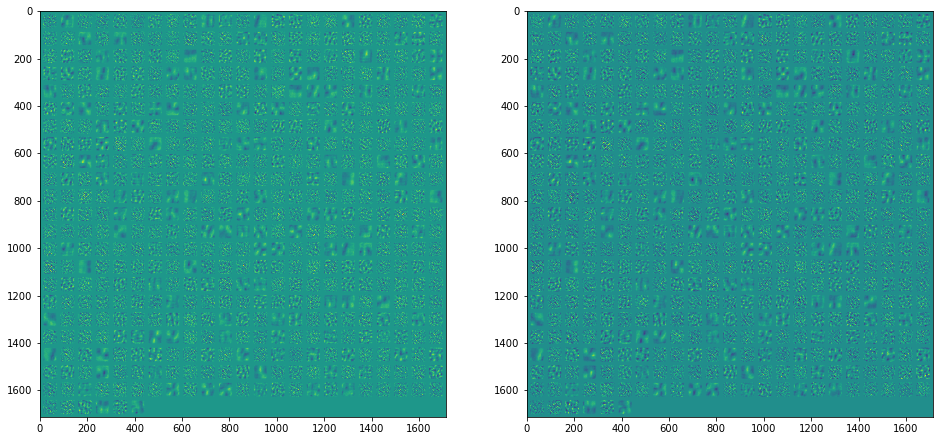

In [12]:
print(model.V1_np.shape)
print(model.U1_np.shape)

import matplotlib.pyplot as plt
import pylab

# function copied from the original code
def dispims(M, height, width, border=0, bordercolor=0.0, layout=None, **kwargs):
    from pylab import cm, ceil
    numimages = M.shape[1]
    if layout is None:
        n0 = int(np.ceil(np.sqrt(numimages)))
        n1 = int(np.ceil(np.sqrt(numimages)))
    else:
        n0, n1 = layout
    im = bordercolor * np.ones(((height+border)*n0+border,(width+border)*n1+border),dtype='<f8')
    for i in range(n0):
        for j in range(n1):
            if i*n1+j < M.shape[1]:
                im[i*(height+border)+border:(i+1)*(height+border)+border,
                   j*(width+border)+border :(j+1)*(width+border)+border] = np.vstack((
                            np.hstack((np.reshape(M[:,i*n1+j],(height, width)),
                                   bordercolor*np.ones((height,border),dtype=float))),
                            bordercolor*np.ones((border,width+border),dtype=float)
                            ))
    
    return im


I = dispims(model.U1_np, 64, 64, 10)
J = dispims(model.V1_np, 64, 64, 10)

fig = plt.figure(figsize=(16,8))
fig.add_subplot(121).imshow(I)
fig.add_subplot(122).imshow(J)

plt.show()